In [214]:
import pandas as pd
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split

In [215]:
data = pd.read_csv('ndtv_data_final.csv')

In [216]:
data.head()

,Unnamed: 0,Name,Brand,Model,Battery capacity (mAh),Screen size (inches),Touchscreen,Resolution x,Resolution y,Processor,...,Rear camera,Front camera,Operating system,Wi-Fi,Bluetooth,GPS,Number of SIMs,3G,4G/ LTE,Price
0,0,OnePlus 7T Pro McLaren Edition,OnePlus,7T Pro McLaren Edition,4085,6.67,Yes,1440,3120,8,...,48.0,16.0,Android,Yes,Yes,Yes,2,Yes,Yes,58998
1,1,Realme X2 Pro,Realme,X2 Pro,4000,6.50,Yes,1080,2400,8,...,64.0,16.0,Android,Yes,Yes,Yes,2,Yes,Yes,27999
2,2,iPhone 11 Pro Max,Apple,iPhone 11 Pro Max,3969,6.50,Yes,1242,2688,6,...,12.0,12.0,iOS,Yes,Yes,Yes,2,Yes,Yes,106900
3,3,iPhone 11,Apple,iPhone 11,3110,6.10,Yes,828,1792,6,...,12.0,12.0,iOS,Yes,Yes,Yes,2,Yes,Yes,62900
4,4,LG G8X ThinQ,LG,G8X ThinQ,4000,6.40,Yes,1080,2340,8,...,12.0,32.0,Android,Yes,Yes,Yes,1,No,No,49990


In [217]:
data = data.drop(['Unnamed: 0'], axis=1)
data = data.convert_dtypes()

In [218]:
data.dtypes

Name                       string
Brand                      string
Model                      string
Battery capacity (mAh)      Int64
Screen size (inches)      Float64
Touchscreen                string
Resolution x                Int64
Resolution y                Int64
Processor                   Int64
RAM (MB)                    Int64
Internal storage (GB)     Float64
Rear camera               Float64
Front camera              Float64
Operating system           string
Wi-Fi                      string
Bluetooth                  string
GPS                        string
Number of SIMs              Int64
3G                         string
4G/ LTE                    string
Price                       Int64
dtype: object

Model as a category is of too high a cardinality to consider all of the data, it might be best to pick outliers. Most likely will not add much to interpretation of results.

In [219]:
px.box(data, 'Price', hover_name = 'Model')

In [220]:
px.box(data.groupby('Brand', as_index=False).Price.mean(), 'Price', hover_name = 'Brand')

In [221]:
brand_mapping = data.groupby('Brand').Price.mean().to_dict()

In [222]:
data['mean_price_brand'] = data['Brand'].map(brand_mapping)

In [223]:
px.box(data['Brand'].value_counts().to_frame().reset_index(), 'Brand', hover_name = 'index')

In [224]:
brand_count_mapping = data['Brand'].value_counts().to_dict()
data['brand_count'] = data['Brand'].map(brand_count_mapping)

In [225]:
%store data

Stored 'data' (DataFrame)


In [226]:
selected_cols = data[[x for x in data.columns if x not in ['Brand', 'Model', 'Name']]]

In [227]:
cates = selected_cols.select_dtypes(exclude=['int64', 'float64']).columns

In [228]:
selected_cols.select_dtypes(exclude=['int64', 'float64'])

,Touchscreen,Operating system,Wi-Fi,Bluetooth,GPS,3G,4G/ LTE
0,Yes,Android,Yes,Yes,Yes,Yes,Yes
1,Yes,Android,Yes,Yes,Yes,Yes,Yes
2,Yes,iOS,Yes,Yes,Yes,Yes,Yes
3,Yes,iOS,Yes,Yes,Yes,Yes,Yes
4,Yes,Android,Yes,Yes,Yes,No,No
...,...,...,...,...,...,...,...
1354,Yes,Android,Yes,Yes,Yes,Yes,No
1355,Yes,Android,Yes,Yes,Yes,Yes,No
1356,Yes,Android,Yes,Yes,No,Yes,No
1357,Yes,Android,Yes,Yes,Yes,Yes,No


In [229]:
y = data.Price

In [230]:
selected_cols = selected_cols.copy()

In [231]:
for c in selected_cols.columns:
    if c not in cates:
        selected_cols[c] = selected_cols[c].astype('float')
    if c in cates:
        selected_cols[c] = selected_cols[c].astype('category')

In [232]:
selected_cols.pop('Price')

0        58998.0
1        27999.0
2       106900.0
3        62900.0
4        49990.0
          ...   
1354      2599.0
1355      2940.0
1356      2999.0
1357      2498.0
1358      3999.0
Name: Price, Length: 1359, dtype: float64

In [233]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [234]:
clf = XGBRegressor(enable_categorical=True, tree_method = 'hist')

In [235]:
X_train, X_test, y_train, y_test = train_test_split(selected_cols, y, test_size=0.2, random_state=42)

In [236]:
# xgboost hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_alpha': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0, 0.25, 0.5, 1.0],
    'tree_method': ['hist'],
    'enable_categorical': [True],
    'n_jobs': [-1],
    'random_state': [42]
}

In [237]:
cl = RandomizedSearchCV(clf, param_grid, n_iter=100, cv=5, verbose=2, n_jobs=-1, random_state=42).fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=1.0, enable_categorical=True, gamma=1.0, learning_rate=0.01, max_depth=7, min_child_weight=4, n_estimators=100, n_jobs=-1, random_state=42, reg_alpha=0.5, reg_lambda=1.0, subsample=0.9, tree_method=hist; total time=   0.4s
[CV] END colsample_bytree=1.0, enable_categorical=True, gamma=1.0, learning_rate=0.01, max_depth=7, min_child_weight=4, n_estimators=100, n_jobs=-1, random_state=42, reg_alpha=0.5, reg_lambda=1.0, subsample=0.9, tree_method=hist; total time=   0.4s
[CV] END colsample_bytree=1.0, enable_categorical=True, gamma=1.0, learning_rate=0.01, max_depth=7, min_child_weight=4, n_estimators=100, n_jobs=-1, random_state=42, reg_alpha=0.5, reg_lambda=1.0, subsample=0.9, tree_method=hist; total time=   0.4s
[CV] END colsample_bytree=1.0, enable_categorical=True, gamma=1.0, learning_rate=0.01, max_depth=7, min_child_weight=4, n_estimators=100, n_jobs=-1, random_state=42, reg_alpha=0.5, reg_lambd

In [238]:
cl.best_estimator_.score(X_test, y_test)

0.7205336741449082

In [239]:
cl.best_estimator_.score(X_train, y_train)

0.8347785627264047

In [243]:
clf = XGBRegressor(**cl.best_params_)
clf.fit(selected_cols, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, gamma=0.25, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=500,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.5, reg_lambda=1.0, ...)

In [ ]:
import seaborn as sns

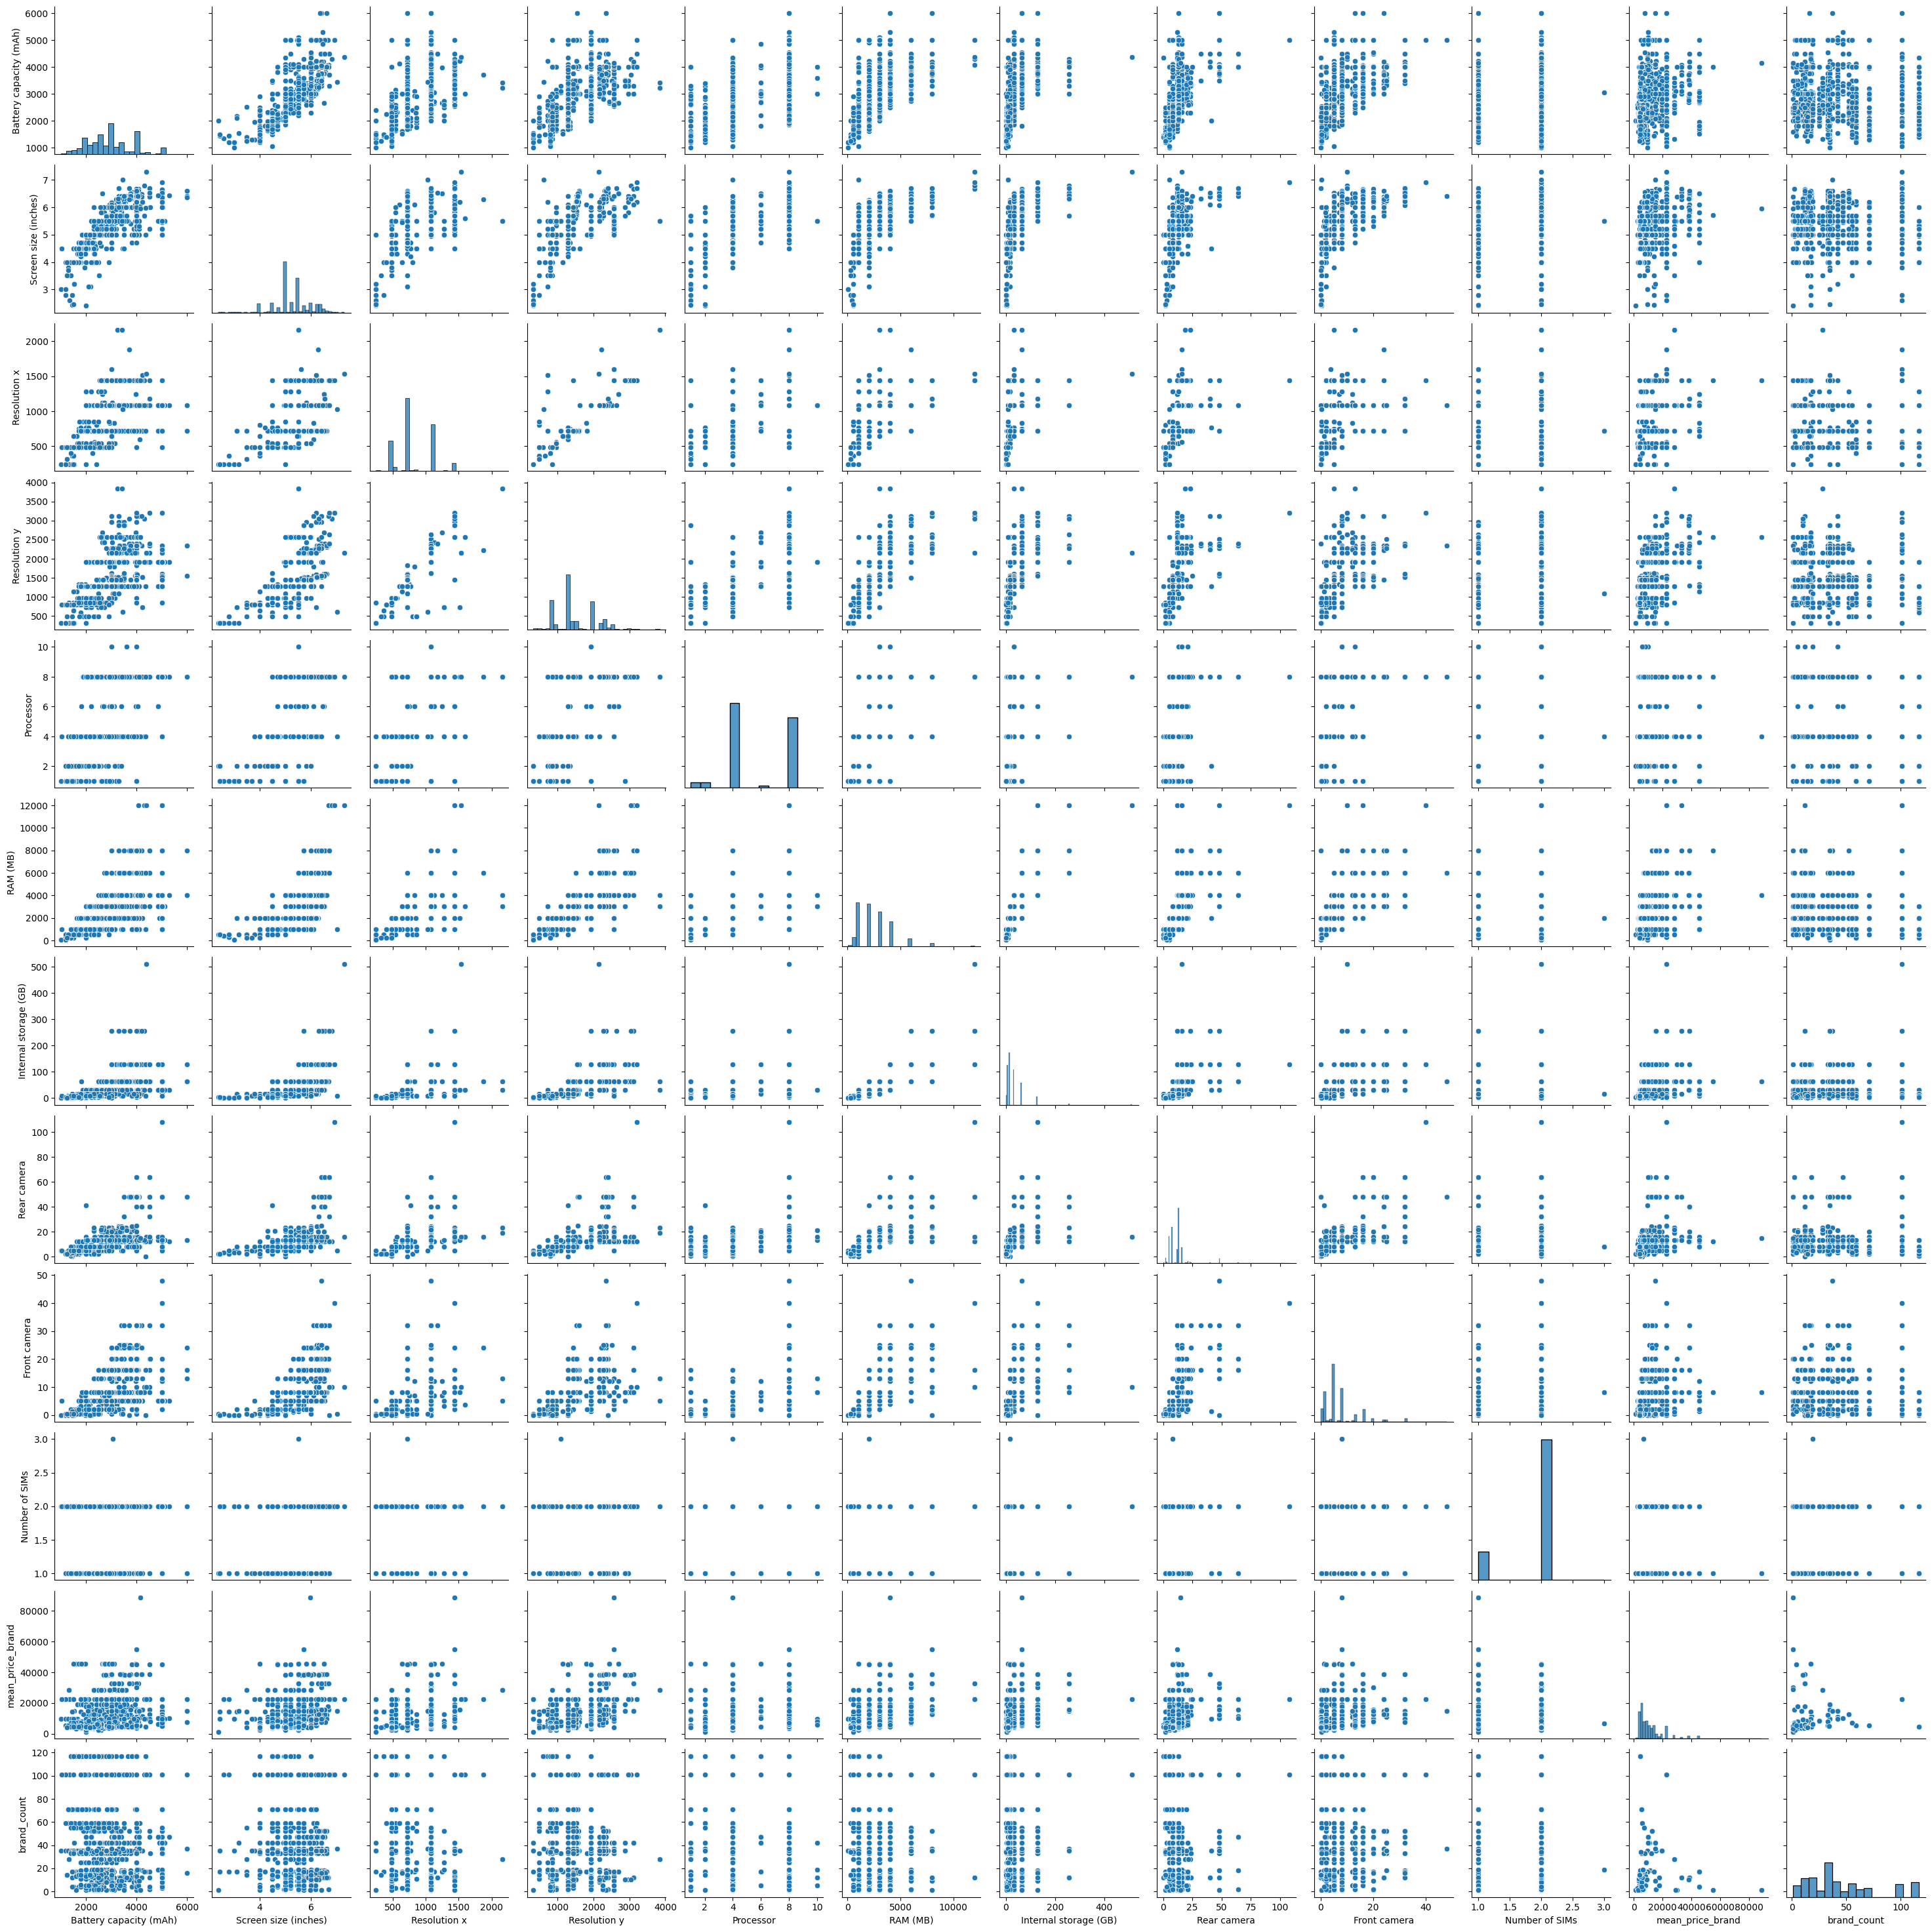

In [ ]:
sns.pairplot(selected_cols.select_dtypes('float'))

In [ ]:
selected_cols['Price'] = y

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


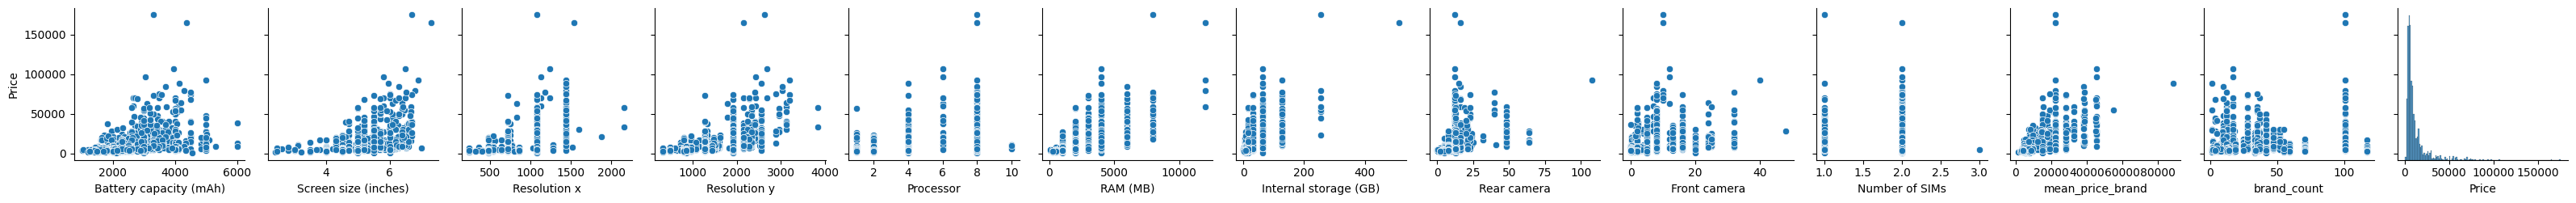

In [ ]:
sns.pairplot(selected_cols, y_vars = ['Price'])

In [ ]:
from category_encoders import CatBoostEncoder

In [ ]:
ndata = data.copy()

In [ ]:
for x in ndata.columns:
    if ndata[x].dtype == 'string':
        ndata[x] = ndata[x].astype('category')
    else:
        ndata[x] = ndata[x].astype('float')

In [ ]:
enc = CatBoostEncoder().fit(ndata, y).transform(ndata, y)
enc.drop('Price', axis=1, inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(enc, y, test_size=0.2, random_state=42)

In [ ]:
enc.dtypes

Name                      float64
Brand                     float64
Model                     float64
Battery capacity (mAh)    float64
Screen size (inches)      float64
Touchscreen               float64
Resolution x              float64
Resolution y              float64
Processor                 float64
RAM (MB)                  float64
Internal storage (GB)     float64
Rear camera               float64
Front camera              float64
Operating system          float64
Wi-Fi                     float64
Bluetooth                 float64
GPS                       float64
Number of SIMs            float64
3G                        float64
4G/ LTE                   float64
mean_price_brand          float64
brand_count               float64
dtype: object

In [ ]:
cl.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=1.0, enable_categorical=True, gamma=1.0, learning_rate=0.01, max_depth=7, min_child_weight=4, n_estimators=100, n_jobs=-1, random_state=42, reg_alpha=0.5, reg_lambda=1.0, subsample=0.9, tree_method=hist; total time=   0.6s
[CV] END colsample_bytree=1.0, enable_categorical=True, gamma=1.0, learning_rate=0.01, max_depth=7, min_child_weight=4, n_estimators=100, n_jobs=-1, random_state=42, reg_alpha=0.5, reg_lambda=1.0, subsample=0.9, tree_method=hist; total time=   0.6s
[CV] END colsample_bytree=1.0, enable_categorical=True, gamma=1.0, learning_rate=0.01, max_depth=7, min_child_weight=4, n_estimators=100, n_jobs=-1, random_state=42, reg_alpha=0.5, reg_lambda=1.0, subsample=0.9, tree_method=hist; total time=   0.6s
[CV] END colsample_bytree=1.0, enable_categorical=True, gamma=1.0, learning_rate=0.01, max_depth=7, min_child_weight=4, n_estimators=100, n_jobs=-1, random_state=42, reg_alpha=0.5, reg_lambd

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=True,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          ma...
                                        'enable_categorical': [True],
                                        'gamma': [0, 0.25, 0.5, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'n_jobs': [-1], 'random_state': [42],
                                        'reg_alpha': [0, 0.25, 0.5, 1.0],
                                        'reg_lambda': [0, 0.25, 0.5, 1.0],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0],
                                        'tree_method': ['hist']},
                   random_state=42, verbose=2)

In [ ]:
cl.score(X_test, y_test)

0.685513694885715

In [ ]:
clf = XGBRegressor(**cl.best_params_)

In [ ]:
clf.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, gamma=1.0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=0.25, ...)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


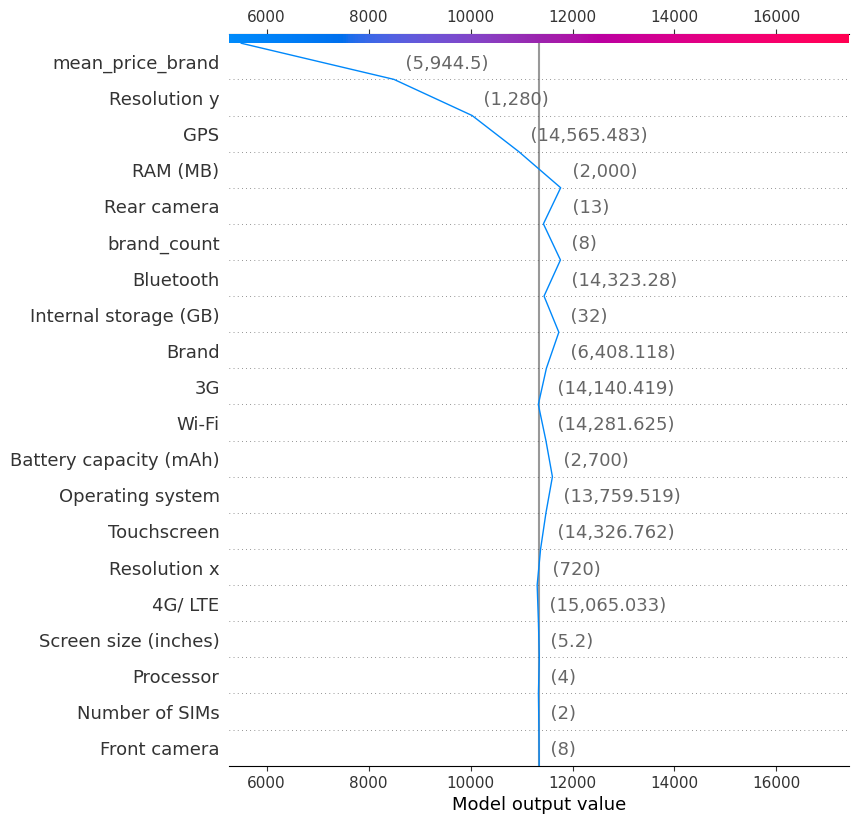

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)
shap.decision_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])